# Proyecto Módulo 2  
**Maestría MACC — Aplicaciones de Aprendizaje de Máquina 2025-1**  
**Profesor:** Nicolás López  

---

## 1. Objetivo

Muchas aplicaciones modernas requieren el procesamiento de datos no estructurados, especialmente textos escritos en lenguaje natural. En este proyecto exploraremos el uso de modelamiento estadístico para representar fragmentos de texto (chunks) como vectores densos (embeddings), los cuales pueden utilizarse posteriormente en tareas complejas mediante técnicas estándar de aprendizaje automático. Utilizaremos estos embeddings para comprender la estructura del texto y además para la clasificación de textos empleando métodos de aprendizaje supervisado.

---

## Estudiantes

- Bryam Camilo Acevedo
- Daniel Dario Fula
- Stiven Paloma Alarcon  

In [2]:
!pip install --quiet -r requirements.txt

In [1]:
# Se importan las librerias que se usaran en el proyecto
import pandas as pd
from preprocessing import MoviePreprocessor
from trainning import LogisticTrainer
from validate import LogisticValidator
import utils

## Carga de Datos

En esta sección se carga el archivo `movies_metadata.csv`, que contiene información relacionada con películas, utilizando la librería `pandas`.

In [2]:
df = pd.read_csv('./src/movies_metadata.csv', low_memory=False)
print(df.shape)

(45466, 24)


## Aplicación del Preprocesador de Películas

Este fragmento de código se encarga de aplicar un preprocesamiento estructurado sobre un conjunto de datos de películas, utilizando una clase personalizada llamada `MoviePreprocessor`.

---

### 🔍 ¿Qué hace este fragmento?

Instancia y ejecuta un preprocesador sobre un `DataFrame` que contiene información de películas. Este preprocesador limpia, transforma y filtra las sinopsis (`overview`) y los géneros (`genres`) con el fin de preparar los datos para tareas posteriores de aprendizaje automático, especialmente clasificación.

---

### ⚙️ Acciones implementadas

1. **Filtrado de sinopsis vacías o nulas**  
   Se eliminan las películas que no tienen sinopsis o que la tienen vacía.

2. **Parseo de géneros**  
   Se convierte la columna `genres`, que viene como un string tipo JSON, en una lista de nombres de géneros.

3. **Filtrado por género único válido**  
   Se conservan únicamente las películas que tienen **exactamente un género**, y este género debe estar en una lista predefinida de géneros considerados válidos (por ejemplo: *Drama, Comedy, Horror*).

4. **Creación de columna `genre`**  
   Se agrega una columna `genre` con el nombre del único género válido por película.

5. **Filtrado de sinopsis unificadas**  
   Se descartan las películas cuya sinopsis se divide en múltiples fragmentos al usar un tokenizador de tipo `SentenceTransformers`, quedándose solo con aquellas que caben en un único bloque de texto.

---

### 📤 ¿Qué devuelve?

El resultado es un nuevo `DataFrame`:

- Limpio y estructurado.
- Solo con películas que tienen una sinopsis coherente y un único género válido.
- Preparado para representar el texto como embeddings y para aplicar modelos supervisados de clasificación.

Este preprocesamiento garantiza que los datos sean consistentes y adecuados para su uso en modelos de aprendizaje automático.


In [3]:
# Instanciar y aplicar el preprocesador
preprocessor = MoviePreprocessor(
    genres_column="genres",
    overview_column="overview",
    chunk_size=500,
    chunk_overlap=0
)

df = preprocessor.preprocess(df)

In [4]:
print(df.shape)

(13745, 24)


## Validación Cruzada para Selección del Modelo de Clasificación

En esta etapa se busca entrenar un modelo de regresión logística para predecir si una película pertenece a un género específico (por ejemplo, *Drama*), a partir de su sinopsis (`overview`). Para lograrlo, se utiliza una clase personalizada llamada `LogisticValidator`, la cual permite seleccionar el mejor hiperparámetro de regularización (C) mediante validación cruzada.

---

### 🎯 ¿Qué hace este fragmento?

1. Se define el género objetivo (`custom_genre = 'Drama'`), que se utilizará como clase positiva (1), mientras que el resto de géneros se consideran negativos (0).
2. Se instancia el objeto `LogisticValidator`, pasando el DataFrame con las películas preprocesadas, el nombre de las columnas relevantes (`overview` y `genre`), los valores de `C` a evaluar, y los parámetros de tokenización (TF-IDF).
3. Se realiza validación cruzada para cada valor de `C`, evaluando el desempeño del modelo mediante el AUC (Área Bajo la Curva ROC).
4. Se selecciona el valor de `C` con mejor AUC promedio.
5. Finalmente, se evalúa el modelo con el mejor `C` encontrado utilizando validación cruzada con 10 pliegos.

---

### ⚙️ Acciones que implementa

- **Vectorización de texto con TF-IDF**:  
  Se transforma la columna `overview` en una matriz de características numéricas usando `TfidfVectorizer`, respetando los parámetros indicados (máximo de palabras, ngramas, etc.).

- **Codificación binaria del target**:  
  Se genera una variable objetivo binaria: `1` si la película pertenece al género seleccionado, `0` en caso contrario.

- **Validación cruzada para selección de C**:  
  Para cada valor de `C` (parámetro de regularización en regresión logística), se entrena el modelo usando `KFold` (por defecto 5 pliegos), y se calcula el AUC promedio en las validaciones.

- **Evaluación final del modelo**:  
  Se entrena y evalúa nuevamente el modelo, esta vez con el mejor `C` encontrado y usando 10 pliegos para obtener una estimación más robusta del rendimiento.

---

### 📤 ¿Qué devuelve?

- Un **diccionario** que asocia cada valor de `C` evaluado con su AUC promedio durante la validación cruzada.
- Un **valor óptimo de `C`** que maximiza el AUC.
- Una **métrica final de desempeño** (AUC promedio en 10-fold CV) que resume la capacidad predictiva del modelo ajustado.

Este procedimiento asegura que el modelo esté correctamente ajustado, evitando sobreajuste y seleccionando automáticamente la fuerza de regularización más adecuada.


In [5]:
# Genero clase 1 para el modelo de clasificación
custom_genre = 'Drama'

In [6]:
# Validación Cruzada para seleccionar mejor C
validator = LogisticValidator(
    df=df,
    text_column="overview",
    genre_column="genre",
    target_genre=custom_genre,
    C_values=[0.01, 0.1, 1.0, 10.0],
    cv_folds=5,
    max_features=50000,
    ngram_range=(1, 1),
    random_state=42
)

In [7]:
# Se realiza el cross-validation al modelo LR
print("***** Cross-validate C *****")
results_cv = validator.cross_validate_C()

***** Cross-validate C *****
C=0.01: AUC promedio 5-fold = 0.7725
C=0.1: AUC promedio 5-fold = 0.8056
C=1.0: AUC promedio 5-fold = 0.8509
C=10.0: AUC promedio 5-fold = 0.8528


In [8]:
# Encontrar C con mayor AUC
best_C = max(results_cv, key=results_cv.get)
print(f"\nMejor C encontrado = {best_C}, AUC = {results_cv[best_C]:.4f}\n")


Mejor C encontrado = 10.0, AUC = 0.8528



In [9]:
# Evaluación final con 10-fold
validator.evaluate_final_model(best_C=best_C, cv_folds=10)

Evaluación final con 10-fold CV y C=10.0 → AUC promedio = 0.8536


0.8536422298253609

## Entrenamiento, Interpretación y Evaluación del Modelo Final

Después de seleccionar el mejor valor del hiperparámetro `C` mediante validación cruzada, se procede a entrenar el modelo final de regresión logística con el conjunto completo de datos, e interpretar sus resultados.

---

### 🎯 ¿Qué hace este fragmento?

1. **Instancia el entrenador `LogisticTrainer`** con el DataFrame de películas, especificando el género objetivo (por ejemplo, `'Drama'`), el mejor valor de `C` y parámetros para la vectorización TF-IDF.
2. **Entrena el modelo sobre todo el conjunto de datos** usando la sinopsis de cada película para predecir si pertenece o no al género objetivo.
3. **Interpreta los coeficientes del modelo**, identificando las palabras más fuertemente asociadas positiva y negativamente con el género seleccionado.
4. **Evalúa el modelo con división train/test**, mostrando la matriz de confusión y la curva ROC.
5. **Genera nubes de palabras por género**, visualizando los términos más frecuentes utilizados en las sinopsis por categoría.

---

### ⚙️ Acciones implementadas

- **Entrenamiento del modelo completo**  
  Se ajusta un modelo de regresión logística sobre el conjunto total de sinopsis vectorizadas usando TF-IDF. Se guarda opcionalmente el modelo en disco (`./src/models`).

- **Interpretación de coeficientes**  
  Se extraen las palabras con los coeficientes más positivos y negativos del modelo. Esto permite identificar qué términos aumentan o disminuyen la probabilidad de que una película sea clasificada dentro del género objetivo.

- **Evaluación con métricas gráficas**  
  Se divide el conjunto de datos en entrenamiento y prueba (por ejemplo, 70/30), y se:
  - Reentrena el vectorizador y el modelo con los datos de entrenamiento.
  - Evalúa el desempeño en el conjunto de prueba.
  - Muestra la matriz de confusión.
  - Traza la curva ROC y calcula el AUC.

- **Visualización por género**  
  Se crean nubes de palabras por cada género presente en el dataset. Estas visualizaciones ayudan a identificar las palabras más comunes en las sinopsis de cada categoría.

---

### 📤 ¿Qué devuelve?

- Un **modelo entrenado** de regresión logística, listo para inferencia o despliegue.
- Las **palabras más representativas del género** (positivas y negativas).
- **Gráficos de evaluación**: matriz de confusión y curva ROC con AUC.
- **Nubes de palabras** por género, guardadas como imágenes si se solicita.

Este módulo integra el entrenamiento y análisis del modelo, facilitando tanto la validación cuantitativa como la interpretación cualitativa del comportamiento del clasificador.


In [10]:
trainer = LogisticTrainer(
    df=df,
    text_column="overview",
    genre_column="genre",
    target_genre=custom_genre,
    C=best_C,
    max_features=5000,
    ngram_range=(1, 1),
    random_state=42
)

model_final = trainer.train_on_full_data()


***** Entrenando modelo final sobre todo el dataset *****


In [11]:
# ------------------------------------------------------------
# 3) Interpretar coeficientes (top 5)
coef_info = trainer.interpret_coefficients(top_n=5)
print(f"\nTop 5 palabras asociadas POSITIVAMENTE a '{custom_genre}':")
for word, coef in coef_info["positivas"]:
    print(f"  {word}: {coef:.4f}")

print("\nTop 5 palabras asociadas NEGATIVAMENTE (clase 0):")
for word, coef in coef_info["negativas"]:
    print(f"  {word}: {coef:.4f}")


Top 5 palabras asociadas POSITIVAMENTE a 'Drama':
  drama: 11.4391
  tragic: 6.2701
  prostitute: 5.8780
  relationship: 5.6883
  pushes: 5.6412

Top 5 palabras asociadas NEGATIVAMENTE (clase 0):
  documentary: -16.9508
  comedy: -12.4941
  horror: -8.5873
  documents: -7.5245
  animated: -7.2910



Evaluación del modelo (Confusion Matrix y ROC):


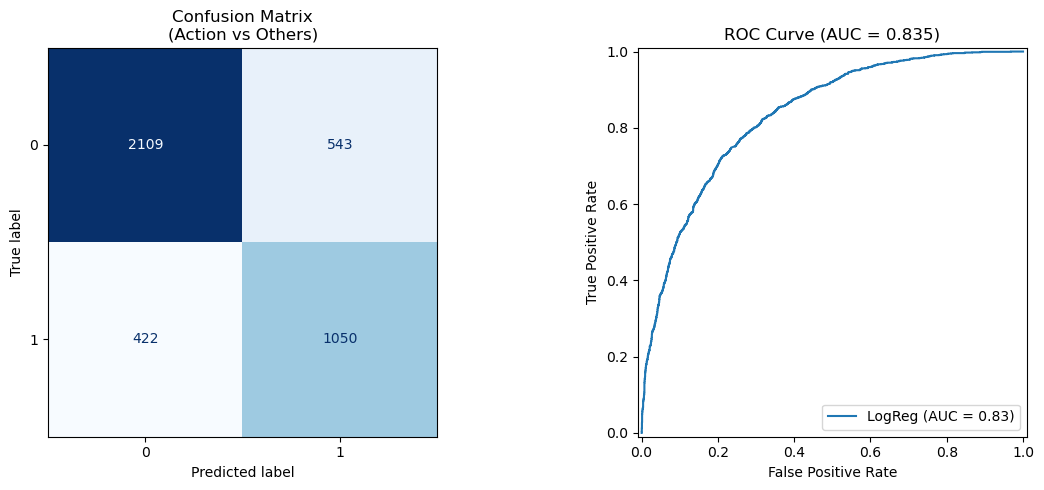

In [12]:
# 4) Evaluar modelo con train/test y mostrar métricas gráficas
print("\nEvaluación del modelo (Confusion Matrix y ROC):")
trainer.evaluate_model(test_size=0.3, save_results=True)

In [13]:
# 5) Generar nubes de palabras para cada género
print("\nGenerando nubes de palabras para cada género...")
trainer.generate_wordclouds(save_results=True)


Generando nubes de palabras para cada género...
Word cloud de 'Comedy' guardada en: ./src/wordclouds/Comedy_wordcloud.png
Word cloud de 'Drama' guardada en: ./src/wordclouds/Drama_wordcloud.png
Word cloud de 'Documentary' guardada en: ./src/wordclouds/Documentary_wordcloud.png
Word cloud de 'Crime' guardada en: ./src/wordclouds/Crime_wordcloud.png
Word cloud de 'Adventure' guardada en: ./src/wordclouds/Adventure_wordcloud.png
Word cloud de 'Science Fiction' guardada en: ./src/wordclouds/Science Fiction_wordcloud.png
Word cloud de 'Thriller' guardada en: ./src/wordclouds/Thriller_wordcloud.png
Word cloud de 'Horror' guardada en: ./src/wordclouds/Horror_wordcloud.png
Word cloud de 'Animation' guardada en: ./src/wordclouds/Animation_wordcloud.png
Word cloud de 'Action' guardada en: ./src/wordclouds/Action_wordcloud.png
Word cloud de 'Western' guardada en: ./src/wordclouds/Western_wordcloud.png
Word cloud de 'Music' guardada en: ./src/wordclouds/Music_wordcloud.png


## Predicción y Evaluación sobre Reseñas Ficticias y Personalizadas

Una vez entrenado el modelo final de regresión logística, se procede a evaluar su capacidad de generalización usando reseñas ficticias diseñadas para representar distintos géneros cinematográficos. Además, se pueden agregar reseñas personalizadas con su género esperado para validar manualmente el comportamiento del clasificador.

---

### 🎯 ¿Qué hace este fragmento?

1. **Predice sobre un conjunto de reseñas ficticias** (sin texto real asociado a películas) usando el modelo entrenado.
2. **Imprime los resultados**, incluyendo la puntuación cruda del modelo (logit score), la probabilidad predicha de pertenecer al género objetivo (`custom_genre`), y una predicción binaria (1 si la probabilidad es mayor o igual a 0.5).
3. **Evalúa una lista ampliada de reseñas** (agrupadas por género) usando la función `evaluate_reviews`.
4. **Visualiza los resultados** mediante:
   - Una **matriz de confusión** binaria (género objetivo vs. otros).
   - Un **gráfico de barras** que compara el género real con el género predicho.

---

### ⚙️ Acciones implementadas

- **Predicción sobre nuevos textos**  
  Se vectorizan las reseñas usando el mismo TF-IDF entrenado y se generan:
  - Puntajes de decisión (`scores`)
  - Probabilidades estimadas (`probs`)
  - Etiquetas binarias (clasificación final según umbral 0.5)

- **Evaluación estructurada con `evaluate_reviews`**  
  Se ejecuta una evaluación más amplia sobre una lista predefinida de 60 reseñas, 5 por cada uno de los 12 géneros válidos. Se pueden agregar reseñas personalizadas al final de esta lista.

- **Visualización de resultados**  
  - **Matriz de confusión**: compara las predicciones contra la verdad real, considerando solo dos clases: el género objetivo vs. los demás.
  - **Gráfico de barras con `seaborn`**: permite observar la distribución de predicciones por género real, diferenciando qué géneros son más o menos confundidos por el modelo.

---

### 📤 ¿Qué devuelve?

- Una **tabla tabulada** con tres columnas: texto de la reseña, género real y género predicho.
- Dos visualizaciones clave:
  - Matriz de confusión (género objetivo vs. otros)
  - Conteo cruzado por género real y predicho
- Un **DataFrame de evaluación**, útil para análisis adicionales (por ejemplo: precisión por clase, análisis de error, etc.)

Este bloque cierra el flujo del modelo combinando inferencia, interpretación y visualización de resultados, permitiendo validar cómo responde el modelo frente a distintos tipos de texto y géneros.


In [14]:
reviews_ficticias = [
    "A covert mission goes awry when the operative’s cover is blown in a high-rise skyscraper.",
    "An estranged father and daughter reunite on a cross-country train journey to reconcile past mistakes.",
    "Two rival food bloggers compete in a chaotic cooking challenge that spirals into absurd pranks.",
    "An in-depth look at the daily rituals of Tibetan monks living in a remote mountain monastery.",
    "A family vacation to an isolated cabin turns nightmarish when ancient runes awaken a vengeful spirit.",
    "A tech-savvy detective races against time to trace a digital ransom note threatening his son.",
    "A fearless marshal must defend a frontier town from a notorious outlaw gang before sunset.",
    "A timid squirrel embarks on an epic quest to rescue his forest friends from a mechanical kingpin.",
    "In a colony on Europa, scientists uncover a mysterious bioluminescent organism that threatens all life.",
    "A brilliant con artist plots an elaborate diamond heist under the nose of a notorious crime boss.",
    "A struggling singer-songwriter finds unexpected fame after her street performance goes viral online.",
    "A daring archaeologist races to decipher clues hidden inside ancient ruins before his rival does."
]
scores, probs = trainer.predict_on_new_texts(reviews_ficticias)

print("\n***** Resultados para reviews ficticias *****")
for i, review in enumerate(reviews_ficticias):
    pred_class = int(probs[i] >= 0.5)
    print(f"Review    : {review}")
    print(f"Score     : {scores[i]:.4f}")
    print(f"Probabilidad (≥0.5 → {custom_genre}=1): {probs[i]:.4f}, Predicción binaria: {pred_class}\n")


***** Resultados para reviews ficticias *****
Review    : A covert mission goes awry when the operative’s cover is blown in a high-rise skyscraper.
Score     : -1.3927
Probabilidad (≥0.5 → Drama=1): 0.1990, Predicción binaria: 0

Review    : An estranged father and daughter reunite on a cross-country train journey to reconcile past mistakes.
Score     : 3.2161
Probabilidad (≥0.5 → Drama=1): 0.9614, Predicción binaria: 1

Review    : Two rival food bloggers compete in a chaotic cooking challenge that spirals into absurd pranks.
Score     : -1.5389
Probabilidad (≥0.5 → Drama=1): 0.1767, Predicción binaria: 0

Review    : An in-depth look at the daily rituals of Tibetan monks living in a remote mountain monastery.
Score     : -1.8838
Probabilidad (≥0.5 → Drama=1): 0.1320, Predicción binaria: 0

Review    : A family vacation to an isolated cabin turns nightmarish when ancient runes awaken a vengeful spirit.
Score     : -3.0934
Probabilidad (≥0.5 → Drama=1): 0.0434, Predicción binaria: 0



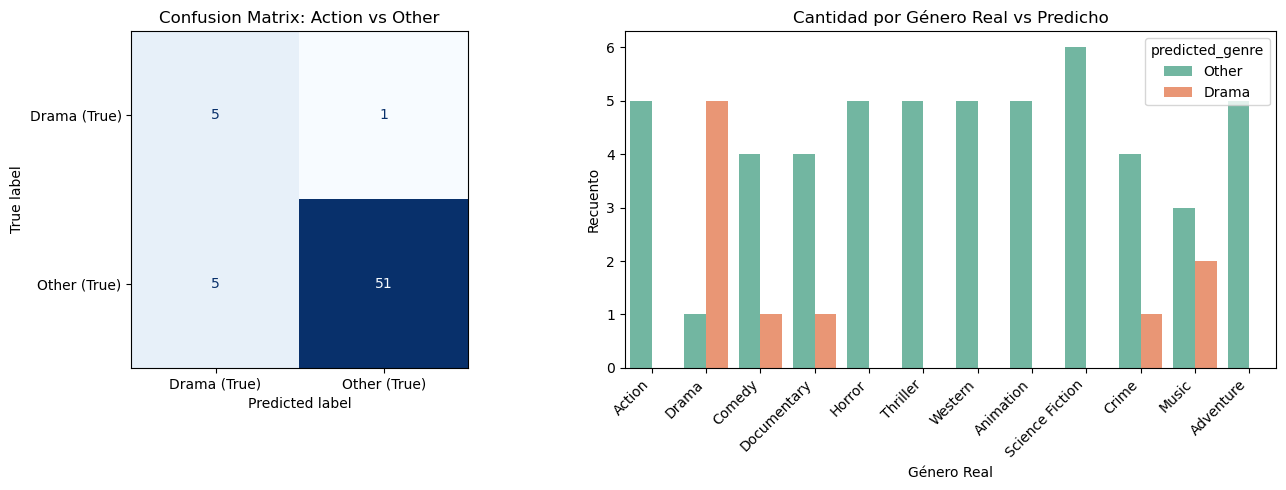

In [15]:
# 3) Si quieres agregar reviews personalizadas:
custom = [
    ("A space odyssey exploring worlds beyond imagination and alien encounters.", "Science Fiction"),
    ("A touching family drama about overcoming adversity in small-town America.", "Drama")
]
df_predicciones_con_custom = utils.evaluate_reviews(trainer, custom_reviews=custom)